In [1]:
# install the dependencies. 
import pandas as pd 
import matplotlib.pyplot as plt 
plt.style.use('ggplot') 

/var/folders/vj/bzsrs8rn3pj96781sygq4hcc0000gn/T/ipykernel_48466/326297450.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# create the list. 
path_policy_rate_list = [
    [ 'graph/1/1/50.csv' , 50 ] , 
    [ "graph/1/1/100.csv" , 100 ] , 
    [ "graph/1/1/200.csv" , 200 ] , 
    [ "graph/1/1/400.csv" , 400 ] , 
    [ "graph/1/1/800.csv" , 800 ] 
] 

In [3]:
# 50Hz -> traj-len = 300 -> maximum reward per episode = 6 * policy rate. 
# 50Hz -> 50 actions per second -> 1 time step is 1/50 sec = 0.02 sec. 

## Research Question. 

1. How quick can we train our policies. 
2. Are high frequency policy rates more robust, better at sim to real transfer? 


# Experiment 1. 

1. In order to get an understanding how the policy rate effects the performance and robustness of the policies, I have decided to test just a few different policies with policy rates that are very different from each other. 
2. Why? I did not want to waste any compute, also training policies with very different policy rates allow us to get an idea about which policy rates are performing better, and which ranges to train in detail. 

### Section 1. 

1. I have trained 5 different policies with different frequencies, which are 50Hz, 100Hz, 200Hz, 400Hz, and 800Hz. 
2. For each of them I kept the max episode length to 6 seconds sim time. (scaled the --traj-len) 
3. For each of them I kept the batch size to 40 seconds sim time. (scaled the --numsteps) 
4. For each of them, Iused an exclusive node with 48 cpus, for 96 hours. 


# Part 1 - Graph. 

### Introduction. 

I have decided to test 5 different policy rates, (50Hz, 100Hz, 200Hz, 400Hz, and 800Hz) and observe how they compare to each other. 

In the main repository, the default policy-rate is 50Hz, traj-len is 300, and the num-steps is 2000. This means that the maximum amount of simulation time each episode can sample is 6 seconds, and the weights of the network are updated every 40 seconds of sampling. I have scaled these according to policy rates, in order to make sure that the comparison is fair. I have have scaled the output metrics such as "Test/Episode Length" and "Test/Reward" according to their policy rates, higher policy rates automatically get more chance to gain more reward. (more time steps per episode) 

I have decided to plot 4 graphs in order to understand how the policy rate effects training. 

### Testing. 

1. Success Rate, regular. 
2. Success Rate, robust. 

### Policies. 

1. 50Hz, 48 hour real time. 
2. 100Hz, 48 real time. 
3. 200Hz, 48 real time. 
4. 400Hz, 48 real time. 
5. 800Hz, 48 real time. 


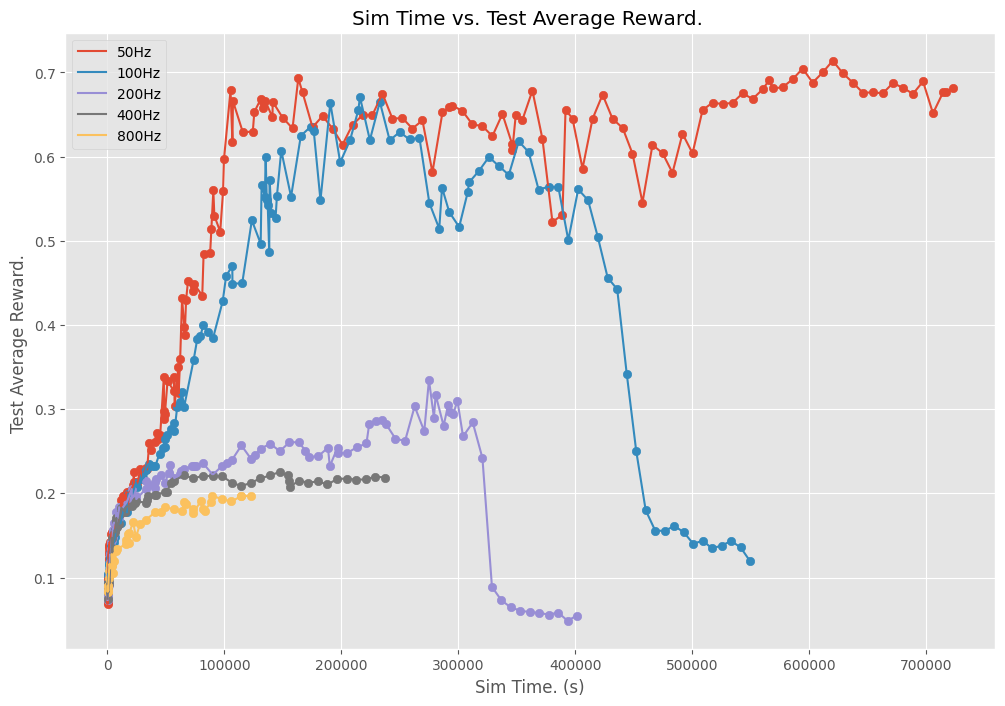

In [4]:
# Create the 1st plot. (A) 
# Sim Time vs. Test Average Reward. 
plt.figure(figsize=(12,8)) 
for csv_file_path , policy_rate in path_policy_rate_list : 
    df = pd.read_csv(csv_file_path) 
    df.replace( {"Test/Return" : ""} , pd.NA , inplace= True)
    df = df.dropna(subset=['Test/Return']) 
    # Create the average return. 
    df['Test/Return'] /= ( 6 * policy_rate ) 
    # Create the sim time. 
    df["Time/Total Timesteps"] /= policy_rate
    plt.scatter(df['Time/Total Timesteps'], df['Test/Return'])
    plt.plot(df['Time/Total Timesteps'], df['Test/Return'], label=f"{policy_rate}Hz")
plt.title('Sim Time vs. Test Average Reward. ') 
plt.xlabel('Sim Time. (s)')
plt.ylabel('Test Average Reward. ') 
plt.legend() 
plt.show() 

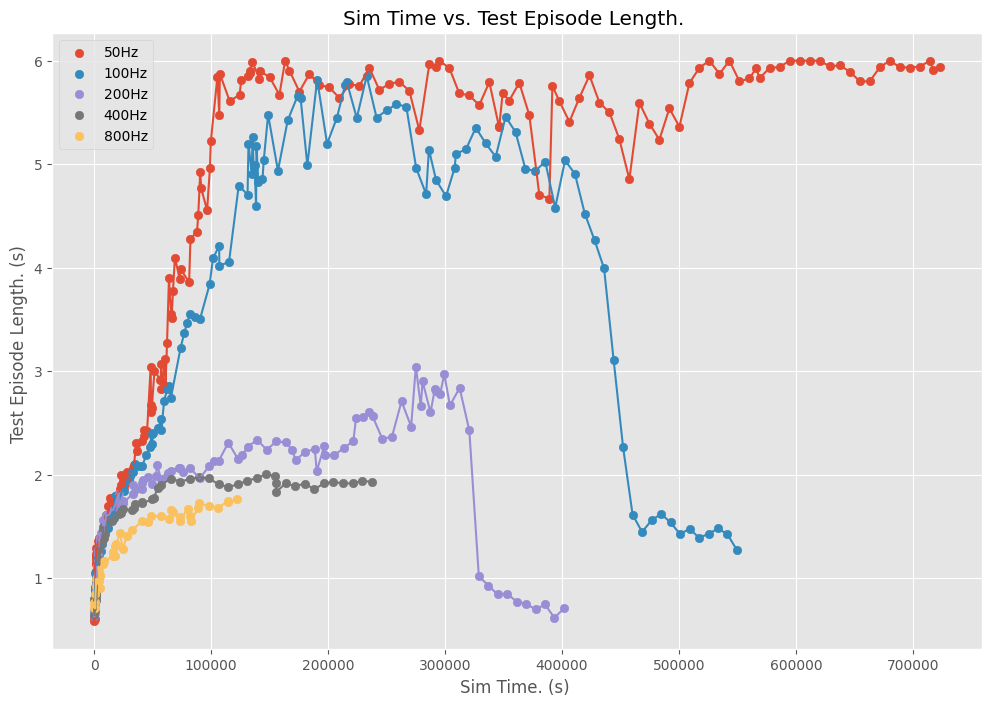

In [5]:
# Create the 1st plot. (B) 
# Sim Time vs. Test Episode Length. 
plt.figure(figsize=(12,8)) 
for csv_file_path , policy_rate in path_policy_rate_list : 
    df = pd.read_csv(csv_file_path) 
    df.replace( {"Test/Episode Length" : ""} , pd.NA , inplace= True)
    df = df.dropna(subset=['Test/Episode Length']) 
    # Create the episode length in seconds. 
    df["Test/Episode Length"] /= policy_rate 
    # Create the sim time. 
    df["Time/Total Timesteps"] /= policy_rate
    plt.scatter(df['Time/Total Timesteps'], df['Test/Episode Length'], label=f"{policy_rate}Hz")
    plt.plot(df['Time/Total Timesteps'], df['Test/Episode Length'])
plt.title('Sim Time vs. Test Episode Length. ') 
plt.xlabel('Sim Time. (s) ')
plt.ylabel('Test Episode Length. (s) ') 
plt.legend() 
plt.show() 

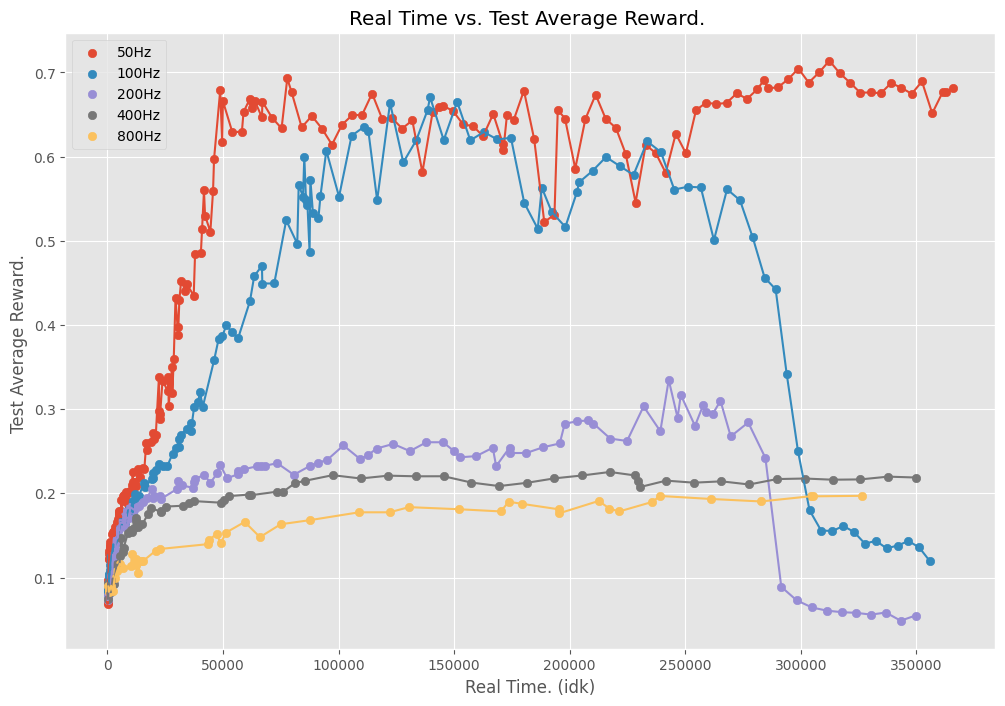

In [6]:
# Create the 2nd plot. (A)
# Relative wall/process time vs. Test Average Reward. 
# TODO: Not sure if this is working. 
plt.figure(figsize=(12,8)) 
for csv_file_path , policy_rate in path_policy_rate_list : 
    df = pd.read_csv(csv_file_path) 
    df['Real Time, Relative'] = df['Time/Timesteps per Iteration'] / df["Time/Timesteps per Second (FULL)"] 
    df['Real Time, Cumulative'] = df['Real Time, Relative'].cumsum() 
    df.replace( {"Test/Return" : ""} , pd.NA , inplace= True)
    df = df.dropna(subset=['Test/Return']) 
    # Create the average return. 
    df['Test/Return'] /= ( 6 * policy_rate ) 
    plt.scatter(df['Real Time, Cumulative'], df['Test/Return'], label=f"{policy_rate}Hz")
    plt.plot(df['Real Time, Cumulative'], df['Test/Return'])
plt.title('Real Time vs. Test Average Reward. ') 
plt.xlabel('Real Time. (idk)')
plt.ylabel('Test Average Reward. ') 
plt.legend() 
plt.show() 

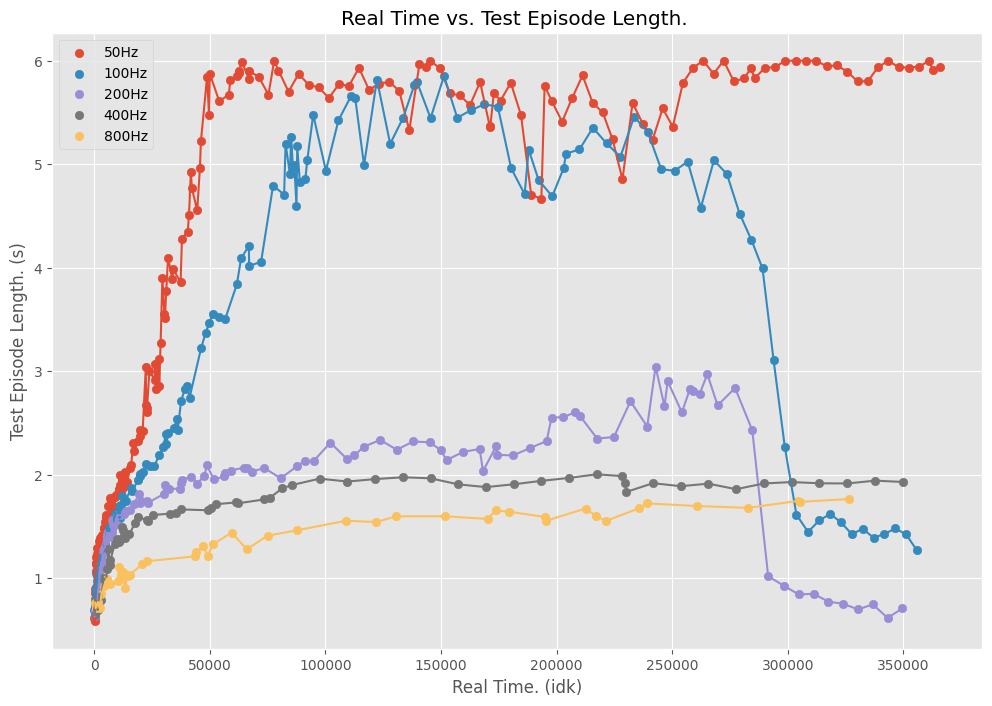

In [7]:
# Create the 2nd plot. (B)
# Relative wall/process time vs. Test Episode Length. 
# TODO: Not sure if this is working. 
plt.figure(figsize=(12,8)) 
for csv_file_path , policy_rate in path_policy_rate_list : 
    df = pd.read_csv(csv_file_path) 
    df['Real Time, Relative'] = df['Time/Timesteps per Iteration'] / df["Time/Timesteps per Second (FULL)"] 
    df['Real Time, Cumulative'] = df['Real Time, Relative'].cumsum()     
    df.replace( {"Test/Episode Length" : ""} , pd.NA , inplace= True)
    df = df.dropna(subset=['Test/Episode Length']) 
    # Create the episode length in seconds. 
    df["Test/Episode Length"] /= policy_rate
    plt.scatter(df['Real Time, Cumulative'], df['Test/Episode Length'] , label=f"{policy_rate}Hz")
    plt.plot(df['Real Time, Cumulative'], df['Test/Episode Length'] )
plt.title('Real Time vs. Test Episode Length. ') 
plt.xlabel('Real Time. (idk)')
plt.ylabel('Test Episode Length. (s)') 
plt.legend() 
plt.show() 

# Part 2 - Robust. 

In [8]:
import re
import numpy as np 
import os 
per_rob = [ 
] 

In [9]:
for policy_rate in [ 50 , 100 , 200 , 400 , 800 ] : 
    for i in range( 31 ) : 
        per_rob.append( [ f"eval/1/1/{policy_rate}/{i}.txt" , policy_rate , i / 100 ] ) 

In [10]:
trial_count = 100 
success_rate_dict = {} 
MAR_dict = {} 
for csv_path , policy_rate , the_noise in per_rob : 
    # Open and read the file 
    if os.path.exists(csv_path):
        with open(csv_path, 'r') as file: 
            # Lists to store the extracted data
            episode_length_list = []
            average_reward_list = []
            sample_output = file.read() 
            # Regex to find episode lengths and average rewards 
            episode_length_pattern = r"Episode length = (\d+)"
            average_reward_pattern = r"Average reward is ([\d\.]+)"
            # Finding all matches in the file content
            episode_length_list = re.findall(episode_length_pattern, sample_output) 
            average_reward_list = re.findall(average_reward_pattern, sample_output)
            # Convert found strings to integers for episode lengths and floats for rewards
            episode_length_list = [int(length) for length in episode_length_list] 
            average_reward_list = [float(reward.rstrip('.')) for reward in average_reward_list] 
            # Find the averages. 
            try : 
                episode_length_list = episode_length_list[:trial_count] 
                average_reward_list = average_reward_list[:trial_count] 
            except : 
                """episode_length_list = episode_length_list[:10] 
                average_reward_list = average_reward_list[:10] """
                episode_length_list = episode_length_list[:trial_count] 
                average_reward_list = average_reward_list[:trial_count] 
            # Calculate the number of elements greater than the threshold 
            threshold = 6 * policy_rate 
            count_greater = np.sum(np.array(episode_length_list) >= threshold)
            # Calculate the percentage of numbers greater than the threshold
            ratio_greater = (count_greater / len( episode_length_list ) ) * 100 
            if policy_rate not in success_rate_dict : 
                success_rate_dict[ policy_rate ] = { "x" : [ the_noise ], "y" : [ ratio_greater ] } 
            else : 
                success_rate_dict[ policy_rate ][ "x" ].append( the_noise ) 
                success_rate_dict[ policy_rate ][ "y" ].append( ratio_greater ) 

            if policy_rate not in MAR_dict : 
                MAR_dict[ policy_rate ] = { "x" : [ the_noise ] , "y" : [ np.mean( average_reward_list ) ] } 
            else : 
                MAR_dict[ policy_rate ]["x"].append( the_noise ) 
                MAR_dict[ policy_rate ]["y"].append( np.mean( average_reward_list ) ) 


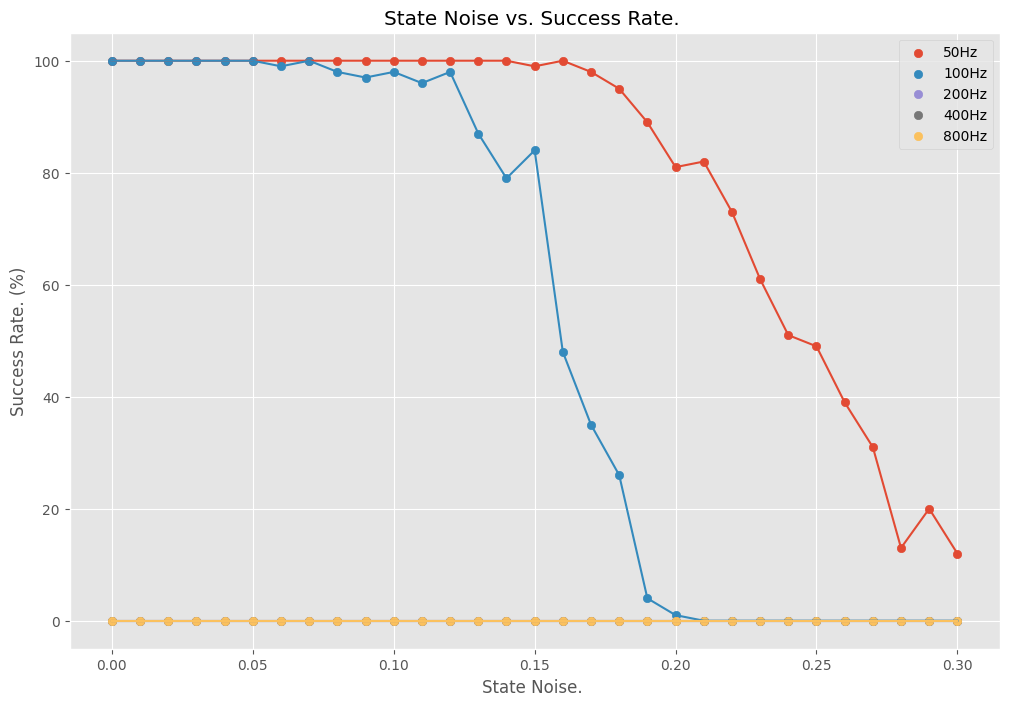

In [11]:
plt.figure(figsize=(12,8)) 
for policy_name in success_rate_dict : 
    pop_count = 0 
    for idx in range( len( success_rate_dict[ policy_name ]["y"] ) ) : 
        if np.isnan( success_rate_dict[ policy_name ]["y"][ idx-pop_count ] ) : 
            success_rate_dict[ policy_name ]["x"].pop(idx - pop_count ) 
            success_rate_dict[ policy_name ]["y"].pop(idx -pop_count) 
            pop_count += 1 
    plt.plot(success_rate_dict[ policy_name ]["x"], success_rate_dict[ policy_name ]["y"]) 
    plt.scatter(success_rate_dict[ policy_name ]["x"], success_rate_dict[ policy_name ]["y"], label=f"{policy_name}Hz")
plt.title('State Noise vs. Success Rate. ') 
plt.xlabel('State Noise. ') 
plt.ylabel('Success Rate. (%)') 
#plt.ylim(-10, 110)  # Set the limits for the y-axis
plt.legend() 
plt.show() 

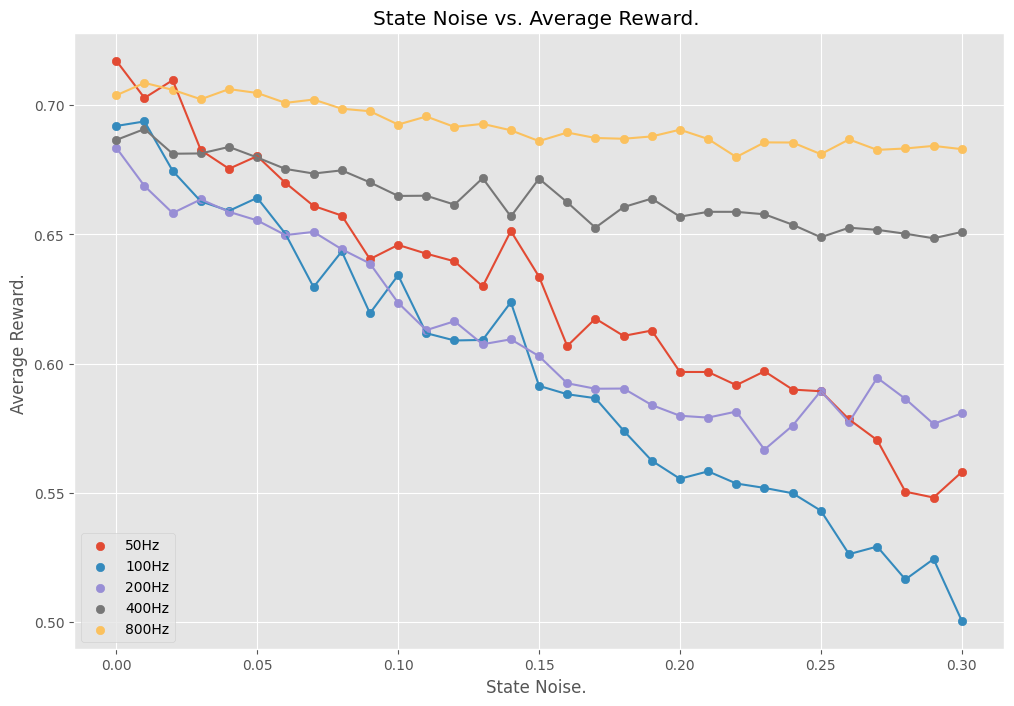

In [12]:
plt.figure(figsize=(12,8)) 
for policy_name in MAR_dict : 
    pop_count = 0 
    for idx in range( len( MAR_dict[ policy_name ]["y"] ) ) : 
        if np.isnan( MAR_dict[ policy_name ]["y"][ idx-pop_count ] ) : 
            MAR_dict[ policy_name ]["x"].pop(idx - pop_count ) 
            MAR_dict[ policy_name ]["y"].pop(idx -pop_count) 
            pop_count += 1 
    plt.plot(MAR_dict[ policy_name ]["x"], MAR_dict[ policy_name ]["y"]) 
    plt.scatter(MAR_dict[ policy_name ]["x"], MAR_dict[ policy_name ]["y"], label=f"{policy_name}Hz")
plt.title('State Noise vs. Average Reward. ') 
plt.xlabel('State Noise. ') 
plt.ylabel('Average Reward. ') 
#plt.ylim(-0.1, 1.1)  # Set the limits for the y-axis
plt.legend() 
plt.show() 

# Experiment 2. 

# Part 1. 

In [13]:
# create the list. 
path_policy_rate_list = [
    [ 'graph/2/10.csv' , 10 ] , 
    [ 'graph/2/20.csv' , 20 ] , 
    [ 'graph/2/30.csv' , 30 ] , 
    [ 'graph/2/40.csv' , 40 ] , 
    [ 'graph/2/50.csv' , 50 ] , 
    [ 'graph/2/60.csv' , 60 ] , 
    [ 'graph/2/70.csv' , 70 ] , 
    [ 'graph/2/80.csv' , 80 ] , 
    [ 'graph/2/90.csv' , 90 ] , 
    [ 'graph/2/100.csv' , 100 ] 
] 

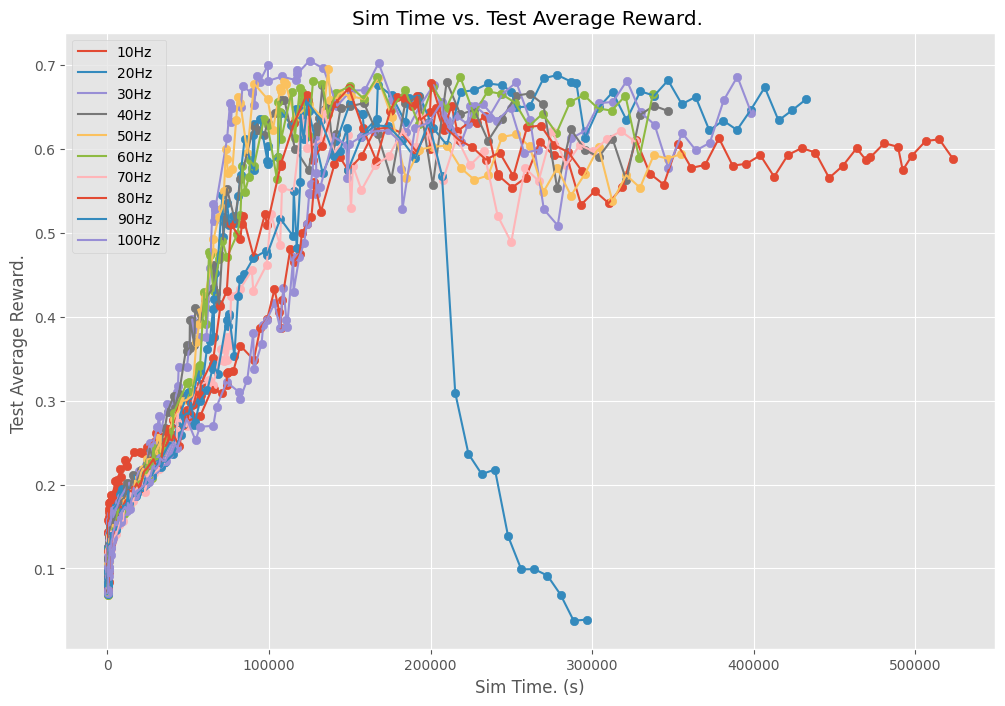

In [14]:
# Create the 1st plot. (A) 
# Sim Time vs. Test Average Reward. 
plt.figure(figsize=(12,8)) 
for csv_file_path , policy_rate in path_policy_rate_list : 
    df = pd.read_csv(csv_file_path) 
    df.replace( {"Test/Return" : ""} , pd.NA , inplace= True)
    df = df.dropna(subset=['Test/Return']) 
    # Create the average return. 
    df['Test/Return'] /= ( 6 * policy_rate ) 
    # Create the sim time. 
    df["Time/Total Timesteps"] /= policy_rate
    plt.scatter(df['Time/Total Timesteps'], df['Test/Return'])
    plt.plot(df['Time/Total Timesteps'], df['Test/Return'], label=f"{policy_rate}Hz")
plt.title('Sim Time vs. Test Average Reward. ') 
plt.xlabel('Sim Time. (s)')
plt.ylabel('Test Average Reward. ') 
plt.legend() 
plt.show() 

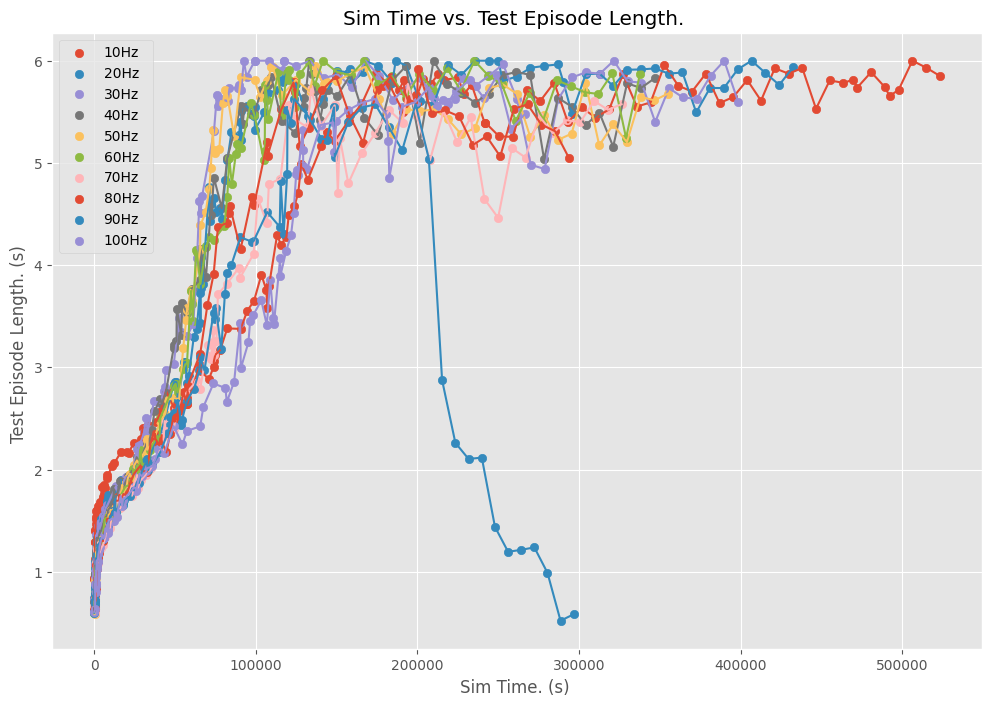

In [15]:
# Create the 1st plot. (B) 
# Sim Time vs. Test Episode Length. 
plt.figure(figsize=(12,8)) 
for csv_file_path , policy_rate in path_policy_rate_list : 
    df = pd.read_csv(csv_file_path) 
    df.replace( {"Test/Episode Length" : ""} , pd.NA , inplace= True)
    df = df.dropna(subset=['Test/Episode Length']) 
    # Create the episode length in seconds. 
    df["Test/Episode Length"] /= policy_rate 
    # Create the sim time. 
    df["Time/Total Timesteps"] /= policy_rate
    plt.scatter(df['Time/Total Timesteps'], df['Test/Episode Length'], label=f"{policy_rate}Hz")
    plt.plot(df['Time/Total Timesteps'], df['Test/Episode Length'])
plt.title('Sim Time vs. Test Episode Length. ') 
plt.xlabel('Sim Time. (s) ')
plt.ylabel('Test Episode Length. (s) ') 
plt.legend() 
plt.show() 

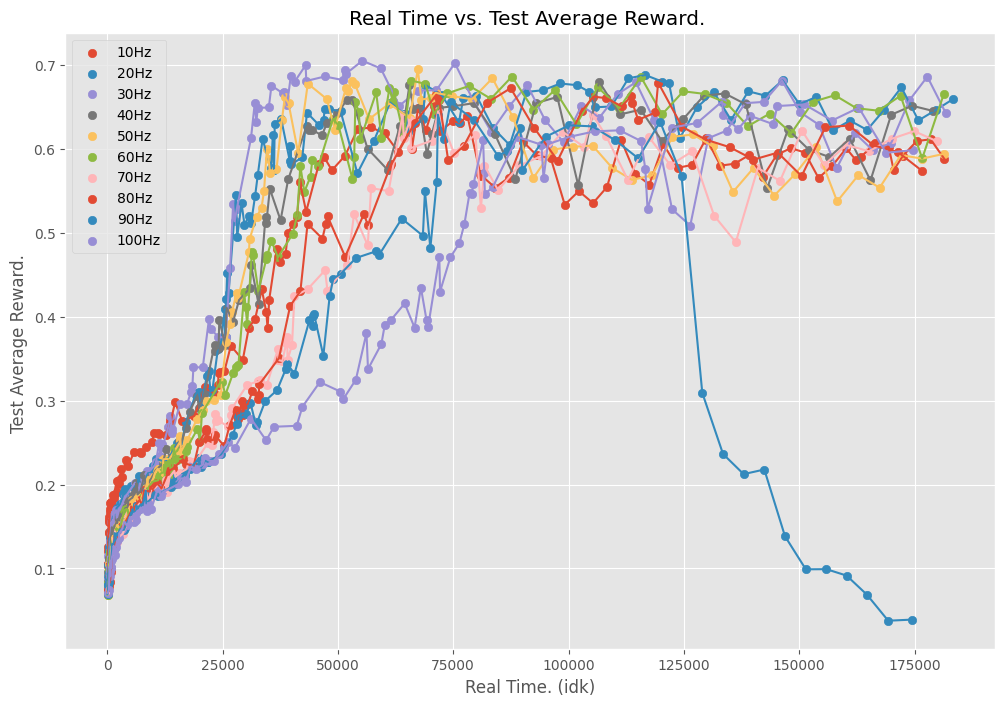

In [16]:
# Create the 2nd plot. (A)
# Relative wall/process time vs. Test Average Reward. 
# TODO: Not sure if this is working. 
plt.figure(figsize=(12,8)) 
for csv_file_path , policy_rate in path_policy_rate_list : 
    df = pd.read_csv(csv_file_path) 
    df['Real Time, Relative'] = df['Time/Timesteps per Iteration'] / df["Time/Timesteps per Second (FULL)"] 
    df['Real Time, Cumulative'] = df['Real Time, Relative'].cumsum() 
    df.replace( {"Test/Return" : ""} , pd.NA , inplace= True)
    df = df.dropna(subset=['Test/Return']) 
    # Create the average return. 
    df['Test/Return'] /= ( 6 * policy_rate ) 
    plt.scatter(df['Real Time, Cumulative'], df['Test/Return'], label=f"{policy_rate}Hz")
    plt.plot(df['Real Time, Cumulative'], df['Test/Return'])
plt.title('Real Time vs. Test Average Reward. ') 
plt.xlabel('Real Time. (idk)')
plt.ylabel('Test Average Reward. ') 
plt.legend() 
plt.show() 

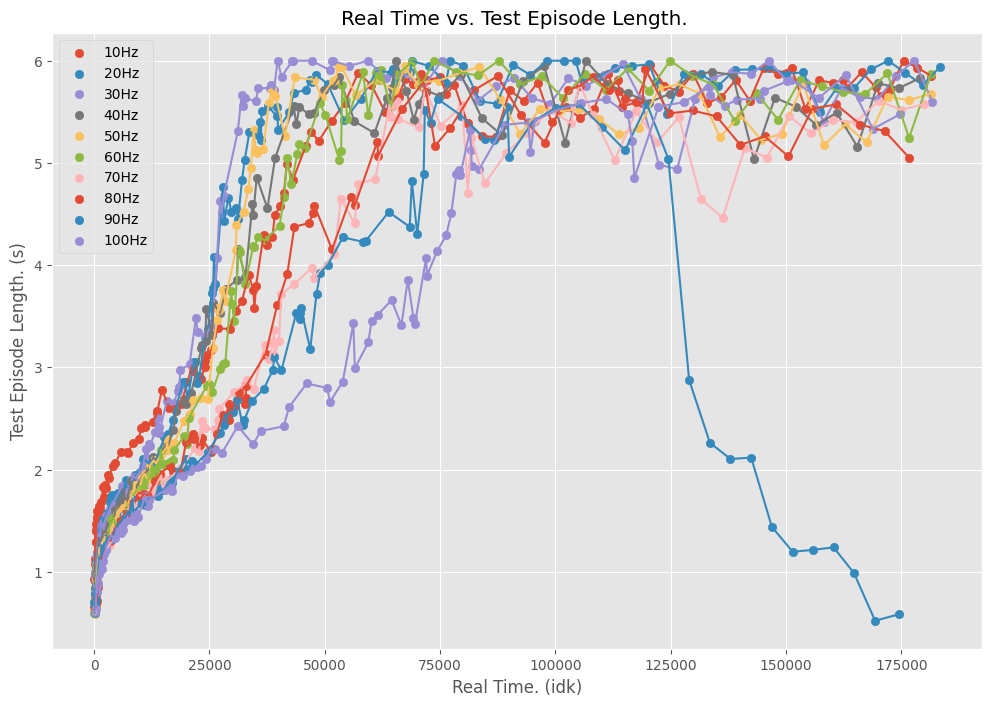

In [17]:
# Create the 2nd plot. (B)
# Relative wall/process time vs. Test Episode Length. 
# TODO: Not sure if this is working. 
plt.figure(figsize=(12,8)) 
for csv_file_path , policy_rate in path_policy_rate_list : 
    df = pd.read_csv(csv_file_path) 
    df['Real Time, Relative'] = df['Time/Timesteps per Iteration'] / df["Time/Timesteps per Second (FULL)"] 
    df['Real Time, Cumulative'] = df['Real Time, Relative'].cumsum()     
    df.replace( {"Test/Episode Length" : ""} , pd.NA , inplace= True)
    df = df.dropna(subset=['Test/Episode Length']) 
    # Create the episode length in seconds. 
    df["Test/Episode Length"] /= policy_rate
    plt.scatter(df['Real Time, Cumulative'], df['Test/Episode Length'] , label=f"{policy_rate}Hz")
    plt.plot(df['Real Time, Cumulative'], df['Test/Episode Length'] )
plt.title('Real Time vs. Test Episode Length. ') 
plt.xlabel('Real Time. (idk)')
plt.ylabel('Test Episode Length. (s)') 
plt.legend() 
plt.show() 

In [27]:
import re
import numpy as np 
import os 
per_rob = [ 
] 

In [28]:
for policy_rate in [ 10 , 20 , 30 , 40 , 50 , 60 , 70  , 80 , 90 , 100 ] : # add 50, 100. 
    for i in range( 31 ) : 
        per_rob.append( [ f"eval/2/{policy_rate}/{i}.txt" , policy_rate , i / 100 ] ) 

In [29]:
trial_count = 100 
success_rate_dict = {} 
MAR_dict = {} 
for csv_path , policy_rate , the_noise in per_rob : 
    # Open and read the file 
    if os.path.exists(csv_path):
        with open(csv_path, 'r') as file: 
            # Lists to store the extracted data
            episode_length_list = []
            average_reward_list = []
            sample_output = file.read() 
            # Regex to find episode lengths and average rewards 
            episode_length_pattern = r"Episode length = (\d+)"
            average_reward_pattern = r"Average reward is ([\d\.]+)"
            # Finding all matches in the file content
            episode_length_list = re.findall(episode_length_pattern, sample_output) 
            average_reward_list = re.findall(average_reward_pattern, sample_output)
            # Convert found strings to integers for episode lengths and floats for rewards
            episode_length_list = [int(length) for length in episode_length_list] 
            average_reward_list = [float(reward.rstrip('.')) for reward in average_reward_list] 
            # Find the averages. 
            try : 
                episode_length_list = episode_length_list[:trial_count] 
                average_reward_list = average_reward_list[:trial_count] 
            except : 
                """episode_length_list = episode_length_list[:10] 
                average_reward_list = average_reward_list[:10] """
                episode_length_list = episode_length_list[:trial_count] 
                average_reward_list = average_reward_list[:trial_count] 
            # Calculate the number of elements greater than the threshold 
            threshold = 6 * policy_rate 
            count_greater = np.sum(np.array(episode_length_list) >= threshold)
            # Calculate the percentage of numbers greater than the threshold
            ratio_greater = (count_greater / len( episode_length_list ) ) * 100 
            if policy_rate not in success_rate_dict : 
                success_rate_dict[ policy_rate ] = { "x" : [ the_noise ], "y" : [ ratio_greater ] } 
            else : 
                success_rate_dict[ policy_rate ][ "x" ].append( the_noise ) 
                success_rate_dict[ policy_rate ][ "y" ].append( ratio_greater ) 

            if policy_rate not in MAR_dict : 
                MAR_dict[ policy_rate ] = { "x" : [ the_noise ] , "y" : [ np.mean( average_reward_list ) ] } 
            else : 
                MAR_dict[ policy_rate ]["x"].append( the_noise ) 
                MAR_dict[ policy_rate ]["y"].append( np.mean( average_reward_list ) ) 


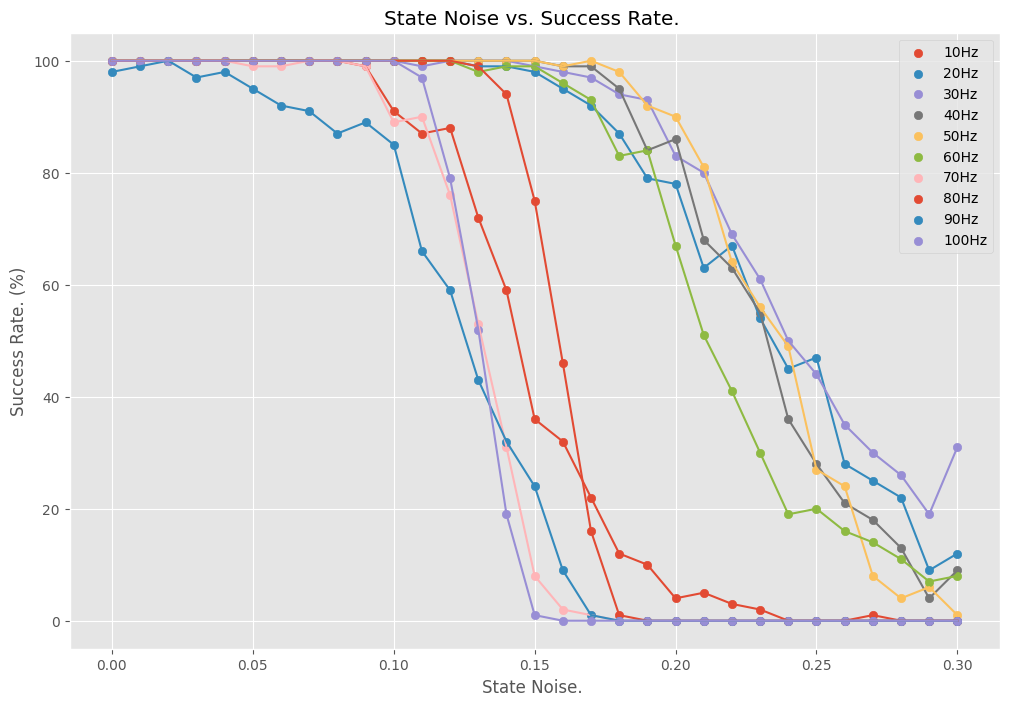

In [30]:
plt.figure(figsize=(12,8)) 
for policy_name in success_rate_dict : 
    pop_count = 0 
    for idx in range( len( success_rate_dict[ policy_name ]["y"] ) ) : 
        if np.isnan( success_rate_dict[ policy_name ]["y"][ idx-pop_count ] ) : 
            success_rate_dict[ policy_name ]["x"].pop(idx - pop_count ) 
            success_rate_dict[ policy_name ]["y"].pop(idx -pop_count) 
            pop_count += 1 
    plt.plot(success_rate_dict[ policy_name ]["x"], success_rate_dict[ policy_name ]["y"]) 
    plt.scatter(success_rate_dict[ policy_name ]["x"], success_rate_dict[ policy_name ]["y"], label=f"{policy_name}Hz")
plt.title('State Noise vs. Success Rate. ') 
plt.xlabel('State Noise. ') 
plt.ylabel('Success Rate. (%)') 
#plt.ylim(-10, 110)  # Set the limits for the y-axis
plt.legend() 
plt.show() 

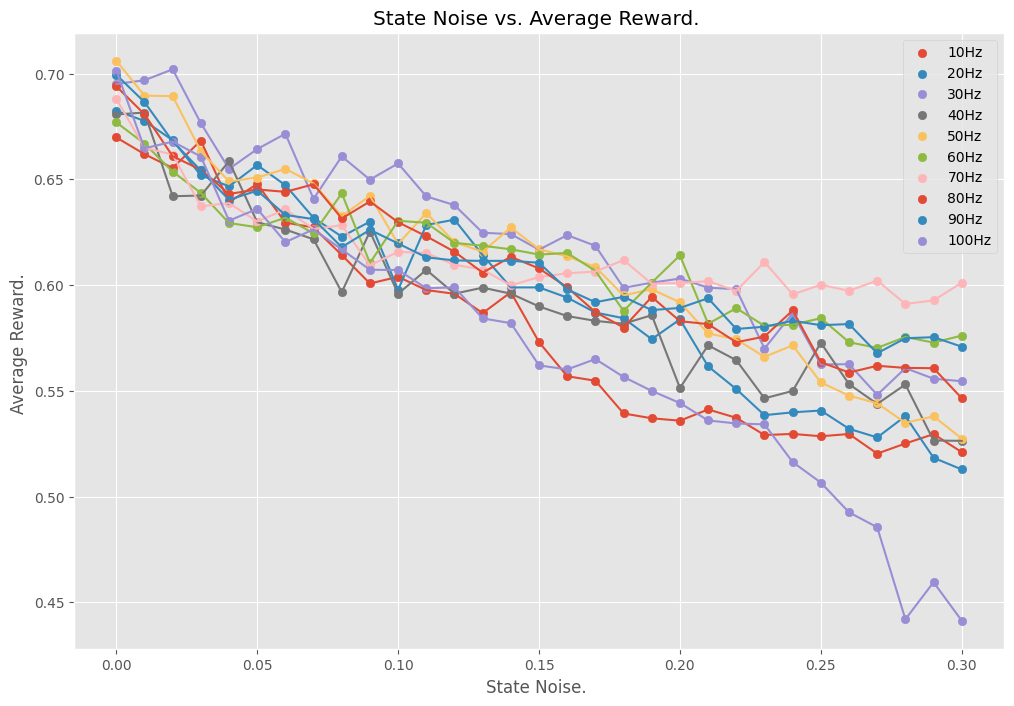

In [31]:
plt.figure(figsize=(12,8)) 
for policy_name in MAR_dict : 
    pop_count = 0 
    for idx in range( len( MAR_dict[ policy_name ]["y"] ) ) : 
        if np.isnan( MAR_dict[ policy_name ]["y"][ idx-pop_count ] ) : 
            MAR_dict[ policy_name ]["x"].pop(idx - pop_count ) 
            MAR_dict[ policy_name ]["y"].pop(idx -pop_count) 
            pop_count += 1 
    plt.plot(MAR_dict[ policy_name ]["x"], MAR_dict[ policy_name ]["y"]) 
    plt.scatter(MAR_dict[ policy_name ]["x"], MAR_dict[ policy_name ]["y"], label=f"{policy_name}Hz")
plt.title('State Noise vs. Average Reward. ') 
plt.xlabel('State Noise. ') 
plt.ylabel('Average Reward. ') 
#plt.ylim(-0.1, 1.1)  # Set the limits for the y-axis
plt.legend() 
plt.show() 